<a href="https://colab.research.google.com/github/AirbornBird88/rdf2vec-umap/blob/main/RDF2Vec2UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyRDF2vec

In [ ]:
pip install rdflib

In [ ]:
# Downloading the data
!wget https://www.dropbox.com/s/naysvkn55jqxxeo/countries.ttl
!wget https://www.dropbox.com/s/ymo3pjfqzscsvey/countries.csv

In [ ]:
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import itertools
from typing import List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdflib
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

import sys
sys.path.append('pyRDF2Vec')
sys.path.append('pyRDF2Vec/pyrdf2vec')

from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.walkers import RandomWalker


In [ ]:
country_data = pd.read_csv('countries.csv')
entities = country_data['Country']
# Something went wrong while retrieving data for a few countries...
entities = list(set(entities) - {
  'http://dbpedia.org/resource/Antigua_and_Barbuda',
 'http://dbpedia.org/resource/Belize',
 'http://dbpedia.org/resource/Bosnia_and_Herzegovina',
 'http://dbpedia.org/resource/Botswana',
 'http://dbpedia.org/resource/Chad',
 'http://dbpedia.org/resource/China',
 'http://dbpedia.org/resource/Georgia',
 'http://dbpedia.org/resource/Guinea',
 'http://dbpedia.org/resource/Ireland',
 'http://dbpedia.org/resource/Malta',
 'http://dbpedia.org/resource/Mexico',
 'http://dbpedia.org/resource/Trinidad_and_Tobago',
 'http://dbpedia.org/resource/Uganda'
 })

In [ ]:
country_data

Country Research Rating  \
0             http://dbpedia.org/resource/Afghanistan             low   
1                 http://dbpedia.org/resource/Albania             low   
2                 http://dbpedia.org/resource/Algeria            high   
3                  http://dbpedia.org/resource/Angola             low   
4     http://dbpedia.org/resource/Antigua_and_Barbuda             low   
..                                                ...             ...   
155                http://dbpedia.org/resource/Uganda            high   
156               http://dbpedia.org/resource/Ukraine            high   
157  http://dbpedia.org/resource/United_Arab_Emirates            high   
158        http://dbpedia.org/resource/United_Kingdom            high   
159         http://dbpedia.org/resource/United_States            high   

    Inflation Rating  Continent  
0               high          1  
1                low          0  
2               high          3  
3               high          3  
4                low          2  
..               ...        ...  
155             high          3  
156              low          0  
157              low          1  
158              low          0  
159              low          2  

[160 rows x 4 columns]

In [ ]:
label_predicates = [
     'http://dbpedia.org/ontology/abstract',
     'http://dbpedia.org/ontology/flag',
     'http://dbpedia.org/ontology/thumbnail',
     'http://dbpedia.org/ontology/wikiPageExternalLink',
     'http://dbpedia.org/ontology/wikiPageID',
     'http://dbpedia.org/ontology/wikiPageRevisionID',
     'http://dbpedia.org/ontology/wikiPageWikiLink',
     'http://dbpedia.org/property/flagCaption',
     'http://dbpedia.org/property/float',
     'http://dbpedia.org/property/footnoteA',
     'http://dbpedia.org/property/footnoteB',
     'http://dbpedia.org/property/footnoteC',
     'http://dbpedia.org/property/source',
     'http://dbpedia.org/property/width',
     'http://purl.org/dc/terms/subject',
     'http://purl.org/linguistics/gold/hypernym',
     'http://purl.org/voc/vrank#hasRank',
     'http://www.georss.org/georss/point',
     'http://www.w3.org/2000/01/rdf-schema#comment',
     'http://www.w3.org/2000/01/rdf-schema#label',
     'http://www.w3.org/2000/01/rdf-schema#seeAlso',
     'http://www.w3.org/2002/07/owl#sameAs',
     'http://www.w3.org/2003/01/geo/wgs84_pos#geometry',
     'http://dbpedia.org/ontology/wikiPageRedirects',
     'http://www.w3.org/2003/01/geo/wgs84_pos#lat',
     'http://www.w3.org/2003/01/geo/wgs84_pos#long',
     'http://www.w3.org/2004/02/skos/core#exactMatch',
     'http://www.w3.org/ns/prov#wasDerivedFrom',
     'http://xmlns.com/foaf/0.1/depiction',
     'http://xmlns.com/foaf/0.1/homepage',
     'http://xmlns.com/foaf/0.1/isPrimaryTopicOf',
     'http://xmlns.com/foaf/0.1/name',
     'http://dbpedia.org/property/website',
     'http://dbpedia.org/property/west',
     'http://dbpedia.org/property/wordnet_type',
     'http://www.w3.org/2002/07/owl#differentFrom',
]

In [ ]:
entities

['http://dbpedia.org/resource/Guyana',
 'http://dbpedia.org/resource/Latvia',
 'http://dbpedia.org/resource/Togo',
 'http://dbpedia.org/resource/Belgium',
 'http://dbpedia.org/resource/Philippines',
 'http://dbpedia.org/resource/Singapore',
 'http://dbpedia.org/resource/Cambodia',
 'http://dbpedia.org/resource/Sudan',
 'http://dbpedia.org/resource/Bulgaria',
 'http://dbpedia.org/resource/Norway',
 'http://dbpedia.org/resource/Peru',
 'http://dbpedia.org/resource/Finland',
 'http://dbpedia.org/resource/Bangladesh',
 'http://dbpedia.org/resource/Qatar',
 'http://dbpedia.org/resource/Maldives',
 'http://dbpedia.org/resource/Mauritius',
 'http://dbpedia.org/resource/Haiti',
 'http://dbpedia.org/resource/Nicaragua',
 'http://dbpedia.org/resource/Greece',
 'http://dbpedia.org/resource/Tajikistan',
 'http://dbpedia.org/resource/Serbia',
 'http://dbpedia.org/resource/Japan',
 'http://dbpedia.org/resource/Bahrain',
 'http://dbpedia.org/resource/Chile',
 'http://dbpedia.org/resource/Comoros',
 '

In [ ]:
import rdflib

kg = KG("countries.ttl",
      skip_predicates=[rdflib.URIRef(x) for x in label_predicates])

In [ ]:
kg

KG(location='countries.ttl', skip_predicates=[rdflib.term.URIRef('http://dbpedia.org/ontology/abstract'), rdflib.term.URIRef('http://dbpedia.org/ontology/flag'), rdflib.term.URIRef('http://dbpedia.org/ontology/thumbnail'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageExternalLink'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageID'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageRevisionID'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageWikiLink'), rdflib.term.URIRef('http://dbpedia.org/property/flagCaption'), rdflib.term.URIRef('http://dbpedia.org/property/float'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteA'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteB'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteC'), rdflib.term.URIRef('http://dbpedia.org/property/source'), rdflib.term.URIRef('http://dbpedia.org/property/width'), rdflib.term.URIRef('http://purl.org/dc/terms/subject'), rdflib.term.URIRef('http://purl

In [ ]:
# Check if 'skip_verify' attribute exists in knowledge_graph
if hasattr(kg, 'skip_verify'):
    print(f'The attribute "skip_verify" exists in knowledge_graph: {kg.skip_verify}')
else:
    print('The attribute "skip_verify" does not exist in knowledge_graph')

The attribute "skip_verify" exists in knowledge_graph: False


In [ ]:
kg

KG(location='countries.ttl', skip_predicates=[rdflib.term.URIRef('http://dbpedia.org/ontology/abstract'), rdflib.term.URIRef('http://dbpedia.org/ontology/flag'), rdflib.term.URIRef('http://dbpedia.org/ontology/thumbnail'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageExternalLink'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageID'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageRevisionID'), rdflib.term.URIRef('http://dbpedia.org/ontology/wikiPageWikiLink'), rdflib.term.URIRef('http://dbpedia.org/property/flagCaption'), rdflib.term.URIRef('http://dbpedia.org/property/float'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteA'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteB'), rdflib.term.URIRef('http://dbpedia.org/property/footnoteC'), rdflib.term.URIRef('http://dbpedia.org/property/source'), rdflib.term.URIRef('http://dbpedia.org/property/width'), rdflib.term.URIRef('http://purl.org/dc/terms/subject'), rdflib.term.URIRef('http://purl

In [ ]:
kg._entities

In [ ]:
# Iterate through the kg._entities list and print the name attribute of each Vertex
for vertex in kg._entities:
    print(vertex.name)

In [ ]:
# Get the names of entities in the knowledge graph
kg_entity_names = [vertex.name for vertex in kg._entities]

# Filter entities based on whether they are present in the knowledge graph
filtered_entities = [e for e in entities if e in kg_entity_names]

# Identify entities that could not be found in the knowledge graph
not_found = set(entities) - set(filtered_entities)

# Print entities that could not be found and remove them
print(f'{not_found} could not be found in the KG! Removing them...')
entities = filtered_entities

set() could not be found in the KG! Removing them...


In [ ]:
# Print the names of the first 5 entities in the 'entities' list
for entity in entities[:5]:
    print(entity)

In [ ]:
# Create our transformer, setting the embedding & walking strategy.
transformer = RDF2VecTransformer(
    Word2Vec(epochs=10),
    walkers=[RandomWalker(4, 10, with_reverse=False, n_jobs=2)],
    # verbose=1
)

In [ ]:
# Get our embeddings.
embeddings, literals = transformer.fit_transform(kg, entities)
print(embeddings)

In [ ]:
# Get our embeddings.
embeddings_2, literals_2 = transformer.fit_transform(kg, entities)
print(embeddings_2)

In [ ]:
print(literals)

[]


In [ ]:
# Save embeddings and literals to CSV
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('embeddings_2.csv', index=False)

In [ ]:
from google.colab import files

files.download('embeddings_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Create a dictionary with entities as keys and embeddings as values
embeddings_dict = {entity: emb.tolist() for entity, emb in zip(entities, embeddings)}

# Save the dictionary to a JSON file
output_path = 'embeddings_data_2.json'
with open(output_path, 'w') as f:
    json.dump(embeddings_dict, f)

print("Embeddings saved to:", output_path)

Embeddings saved to: embeddings_data_2.json


In [ ]:
from google.colab import files

files.download('embeddings_data_2.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install adjustText

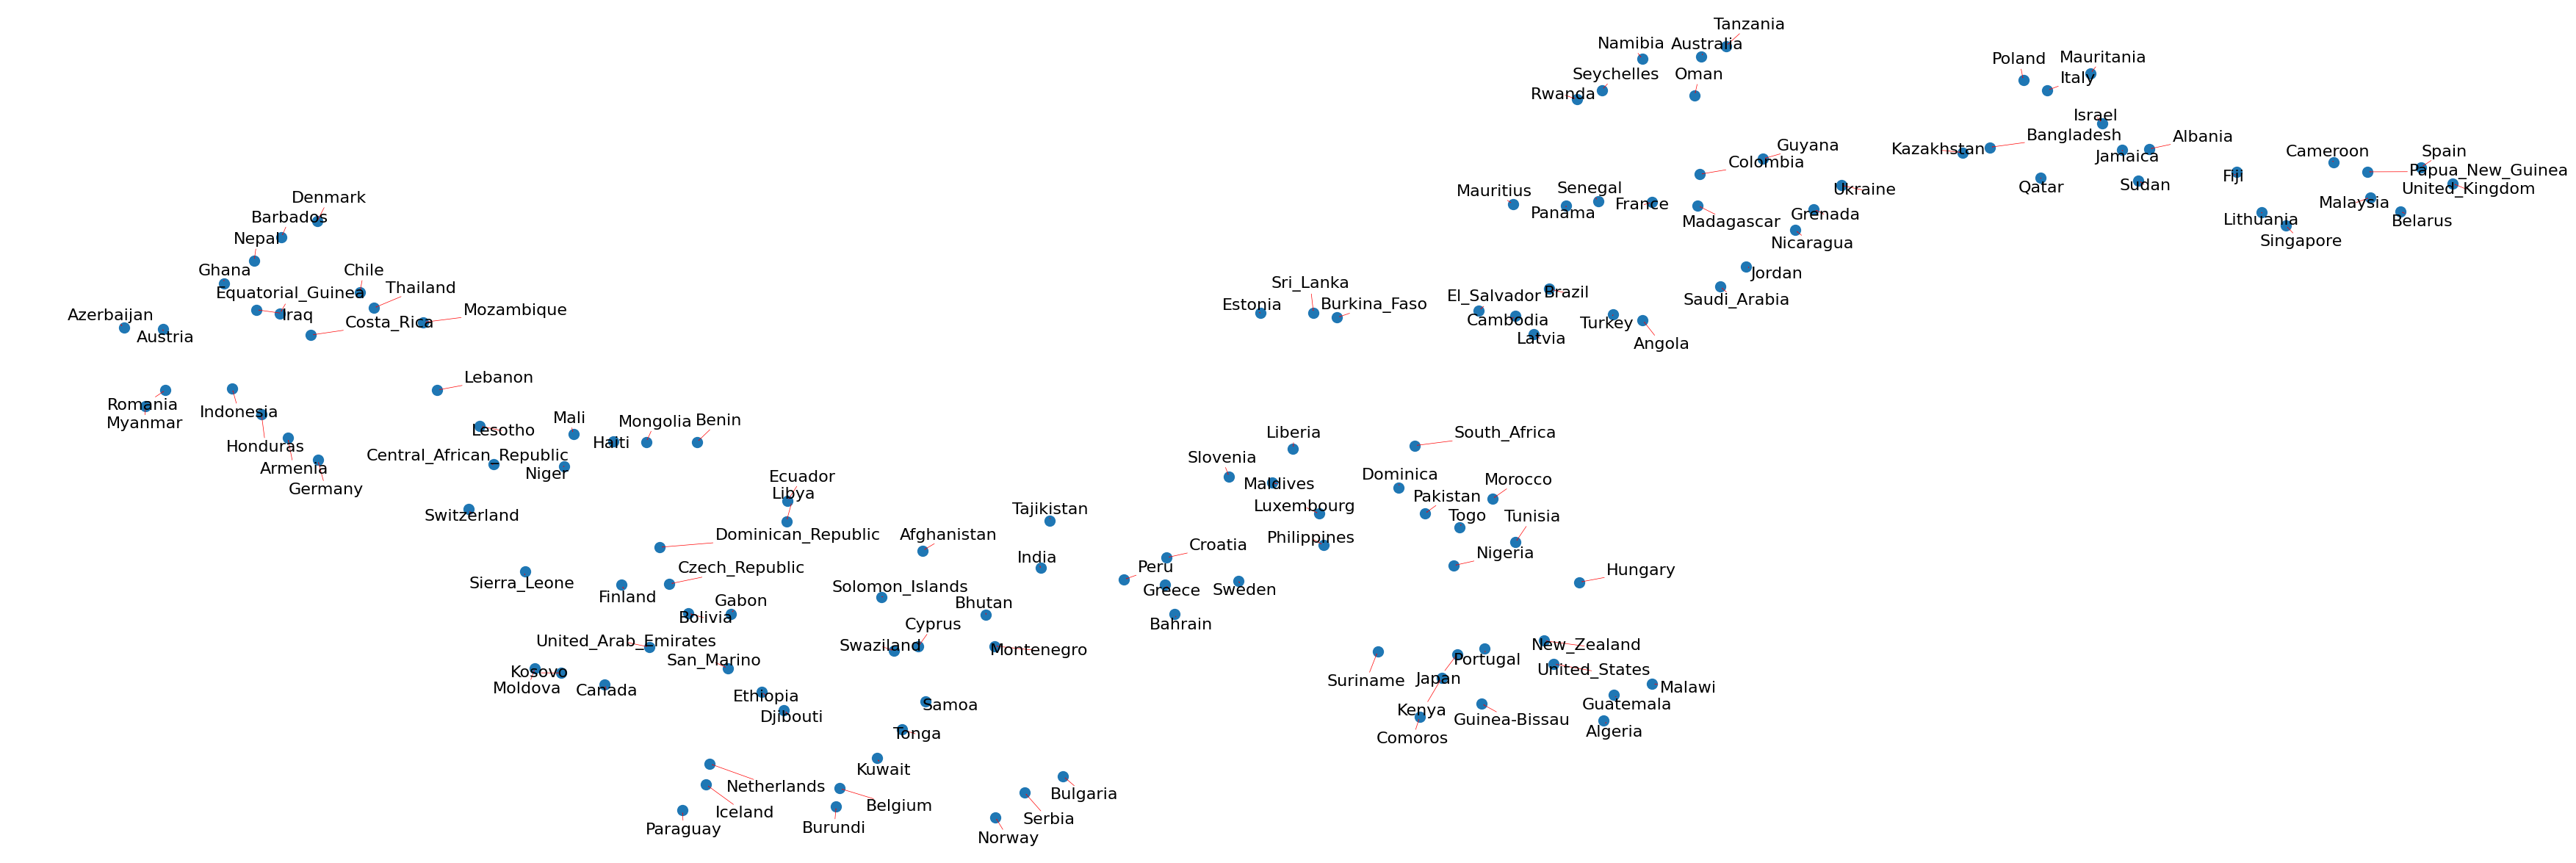

In [ ]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

walk_tsne = TSNE(random_state=42, perplexity=5)
X_tsne = walk_tsne.fit_transform(embeddings_array)

plt.figure(figsize=(45, 15))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=100)

texts = []
for x, y, lab in zip(X_tsne[:, 0], X_tsne[:, 1], entities):
    lab = lab.split('/')[-1]
    text = plt.text(x, y, lab, fontsize=16)
    texts.append(text)

adjust_text(texts, iter_lim=50, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.show()

In [ ]:
!pip install umap-learn

In [ ]:
!pip install hdbscan

In [ ]:
!pip install plotly

In [ ]:
!pip install --upgrade nbformat
!pip install --upgrade plotly

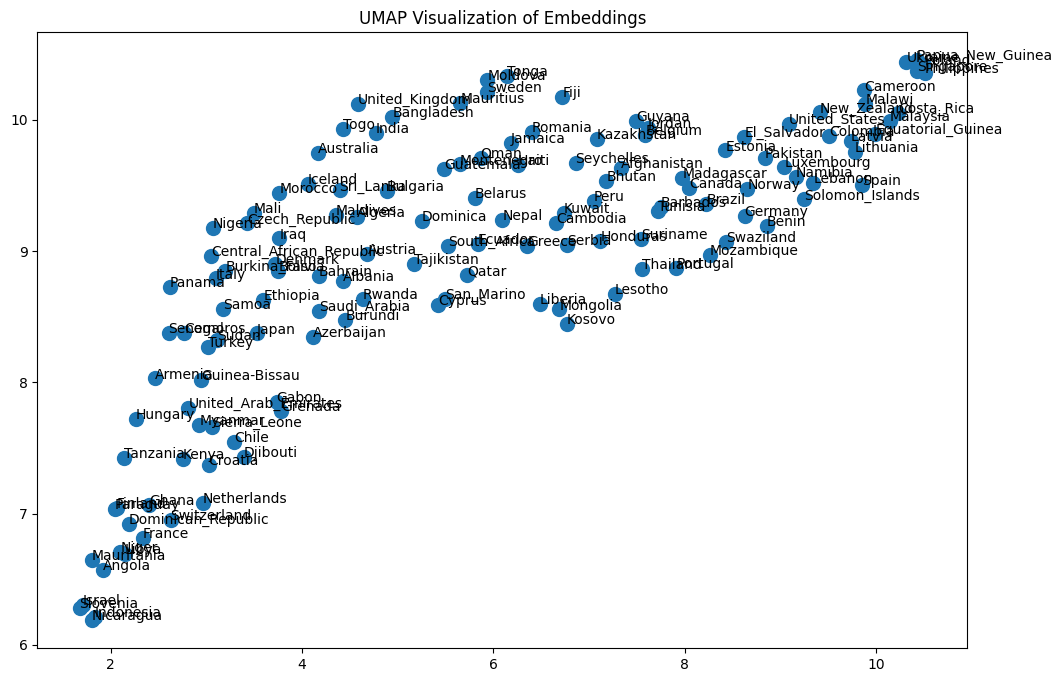

In [ ]:
import umap
import matplotlib.pyplot as plt
from umap import UMAP

# Step 1: Compute UMAP Embeddings
umap_model = UMAP(random_state=42)
X_low_dim = umap_model.fit_transform(embeddings)

# Plot the UMAP visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=100)

# Annotate points with entity labels
for x, y, lab in zip(X_umap[:, 0], X_umap[:, 1], entities):
    lab = lab.split('/')[-1]
    plt.text(x, y, lab, fontsize=10)

plt.title('UMAP Visualization of Embeddings')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Step 2: Invert UMAP Transform
X_inverted = umap_model.inverse_transform(X_low_dim)

# Step 3: Calculate Reconstruction Error
reconstruction_error = mean_squared_error(embeddings, X_inverted)

print(f"Reconstruction Error: {reconstruction_error}")

Reconstruction Error: 0.00025721575366333127


In [ ]:
import umap
import matplotlib.pyplot as plt
from adjustText import adjust_text
import hdbscan
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, mean_squared_error

# Assuming embeddings is your original high-dimensional embeddings array
# Assuming entities is your corresponding entity labels

# Values to try for n_neighbors and min_dist
n_neighbors_values = [3, 5, 10, 15, 20]
min_dist_values = [0.1, 0.5, 0.9]

best_reconstruction_error = float('inf')  # Initialize with a value that needs to be minimized
best_params = None

# Iterate over different values of n_neighbors and min_dist
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        # Calculate UMAP embeddings
        X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42).fit_transform(embeddings)

        # Perform HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
        cluster_labels = clusterer.fit_predict(X_umap)

        # Print the number of clusters (-1 indicates outliers)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        print(f"Number of Clusters: {num_clusters}")

         # Compute Silhouette Score
        silhouette = silhouette_score(X_umap, cluster_labels)
        print(f"Silhouette Score (n_neighbors={n_neighbors}, min_dist={min_dist}): {silhouette}")

        # Compute Davies-Bouldin Index
        db_index = davies_bouldin_score(X_umap, cluster_labels)
        print(f"Davies-Bouldin Index (n_neighbors={n_neighbors}, min_dist={min_dist}): {db_index}")

        # Calculate Reconstruction Error
        X_inverted = umap_model.inverse_transform(X_umap)
        reconstruction_error = mean_squared_error(embeddings, X_inverted)
        print(f"Reconstruction Error (n_neighbors={n_neighbors}, min_dist={min_dist}): {reconstruction_error}")

         # Update best parameters if the current combination has a lower reconstruction error
        if reconstruction_error < best_reconstruction_error:
            best_reconstruction_error = reconstruction_error
            best_params = (n_neighbors, min_dist)
"""
        # Visualize with different colors for each cluster using matplotlib
        plt.figure(figsize=(12, 8))

        # Adjust the size (s) and alpha for better visualization
        scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

        # Annotate points with entity labels and cluster labels
        texts = []
        for x, y, lab, cluster_label in zip(X_umap[:, 0], X_umap[:, 1], entities, cluster_labels):
            lab_short = lab.split('/')[-1]
            text_color = 'red' if cluster_label == -1 else 'black'
            text = plt.text(x, y, f"{lab_short} ({cluster_label})", fontsize=8, color=text_color)
            texts.append(text)

        # Adjust text labels to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), iter_lim=50)

        plt.title(f'UMAP Visualization with HDBSCAN Clusters and Entity Labels (n_neighbors={n_neighbors}, min_dist={min_dist})')
        plt.show()
"""
# Print the best parameters
print(f"Best Hyperparameters: n_neighbors={best_params[0]}, min_dist={best_params[1]}")

Number of Clusters: 13
Silhouette Score (n_neighbors=3, min_dist=0.1): 0.49321359395980835
Davies-Bouldin Index (n_neighbors=3, min_dist=0.1): 0.8989021182153304
Reconstruction Error (n_neighbors=3, min_dist=0.1): 0.0002566082985140383
Number of Clusters: 11
Silhouette Score (n_neighbors=3, min_dist=0.5): 0.21565933525562286
Davies-Bouldin Index (n_neighbors=3, min_dist=0.5): 2.800748017028783
Reconstruction Error (n_neighbors=3, min_dist=0.5): 0.00022624991834163666
Number of Clusters: 8
Silhouette Score (n_neighbors=3, min_dist=0.9): 0.03935309872031212
Davies-Bouldin Index (n_neighbors=3, min_dist=0.9): 2.482075496853456
Reconstruction Error (n_neighbors=3, min_dist=0.9): 0.002794529777020216
Number of Clusters: 13
Silhouette Score (n_neighbors=5, min_dist=0.1): 0.3639026880264282
Davies-Bouldin Index (n_neighbors=5, min_dist=0.1): 0.8002460756747775
Reconstruction Error (n_neighbors=5, min_dist=0.1): 0.00027521696756593883
Number of Clusters: 14
Silhouette Score (n_neighbors=5, min

In [ ]:
n_neighbors = 3  # Adjust the number of neighbors as needed
min_dist = 0.5

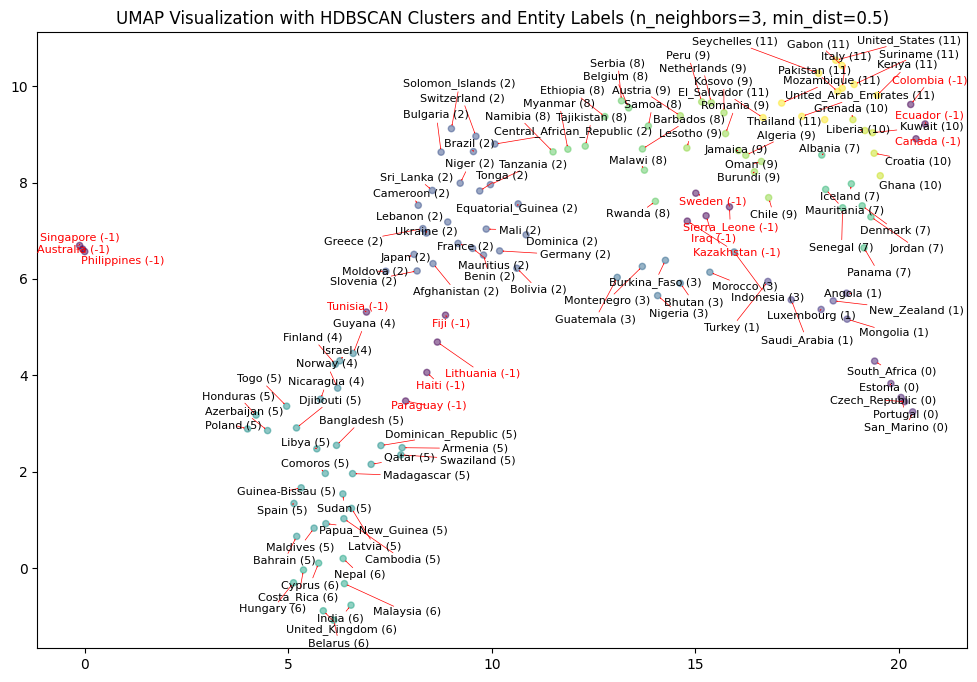

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import hdbscan
import umap

X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42).fit_transform(embeddings)

# Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
cluster_labels = clusterer.fit_predict(X_umap)

# Visualize with different colors for each cluster using matplotlib
plt.figure(figsize=(12, 8))

# Adjust the size (s) and alpha for better visualization
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

# Annotate points with entity labels and cluster labels
texts = []
for x, y, lab, cluster_label in zip(X_umap[:, 0], X_umap[:, 1], entities, cluster_labels):
    lab_short = lab.split('/')[-1]
    text_color = 'red' if cluster_label == -1 else 'black'
    text = plt.text(x, y, f"{lab_short} ({cluster_label})", fontsize=8, color=text_color)
    texts.append(text)

# Adjust text labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), iter_lim=50)

plt.title(f'UMAP Visualization with HDBSCAN Clusters and Entity Labels (n_neighbors={n_neighbors}, min_dist={min_dist})')
plt.show()

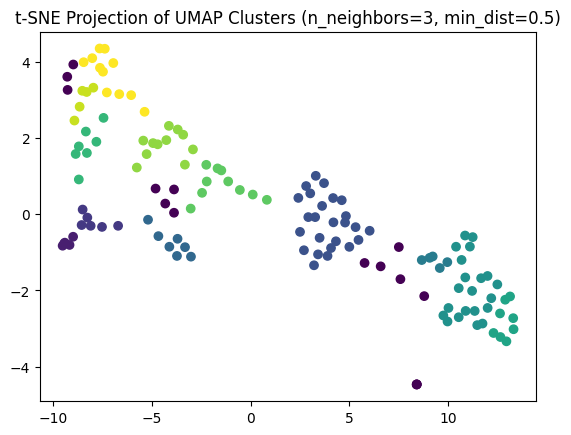

In [ ]:
# Visualize the t-SNE projection with HDBSCAN clusters
X_tsne = TSNE(n_components=2).fit_transform(X_umap)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f't-SNE Projection of UMAP Clusters (n_neighbors={n_neighbors}, min_dist={min_dist})')
plt.show()

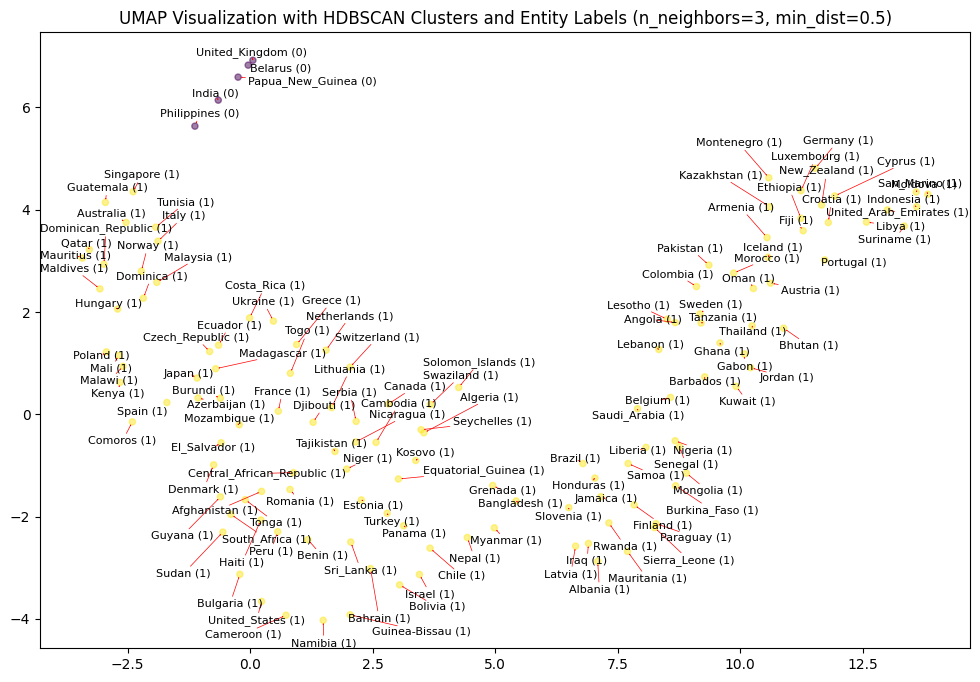

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import hdbscan
import umap

X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42).fit_transform(embeddings_2)

# Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
cluster_labels = clusterer.fit_predict(X_umap)

# Visualize with different colors for each cluster using matplotlib
plt.figure(figsize=(12, 8))

# Adjust the size (s) and alpha for better visualization
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

# Annotate points with entity labels and cluster labels
texts = []
for x, y, lab, cluster_label in zip(X_umap[:, 0], X_umap[:, 1], entities, cluster_labels):
    lab_short = lab.split('/')[-1]
    text_color = 'red' if cluster_label == -1 else 'black'
    text = plt.text(x, y, f"{lab_short} ({cluster_label})", fontsize=8, color=text_color)
    texts.append(text)

# Adjust text labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), iter_lim=50)

plt.title(f'UMAP Visualization with HDBSCAN Clusters and Entity Labels (n_neighbors={n_neighbors}, min_dist={min_dist})')
plt.show()

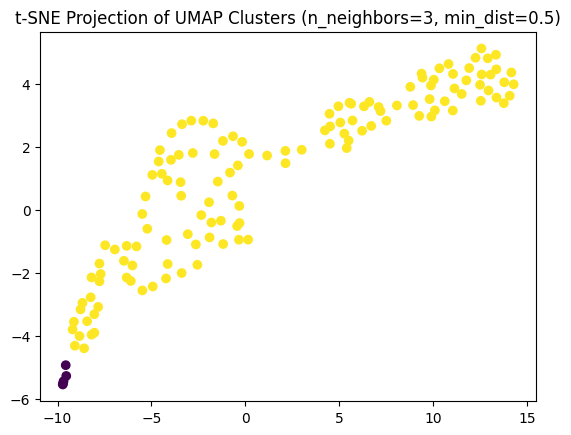

In [ ]:
# Visualize the t-SNE projection with HDBSCAN clusters
X_tsne = TSNE(n_components=2).fit_transform(X_umap)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f't-SNE Projection of UMAP Clusters (n_neighbors={n_neighbors}, min_dist={min_dist})')
plt.show()

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes (clusters)
G.add_nodes_from(unique_clusters)

# Add edges based on cluster connections (customize as needed)
# For example, connect clusters with similar entities or close proximity
G.add_edge(cluster1, cluster2)

# Visualize the graph
pos = nx.spring_layout(G)  # Or choose another layout algorithm
nx.draw(G, pos, with_labels=True, node_color=cluster_labels, cmap='viridis')
plt.title('Network Analysis of UMAP Clusters')
plt.show()


NameError: name 'unique_clusters' is not defined

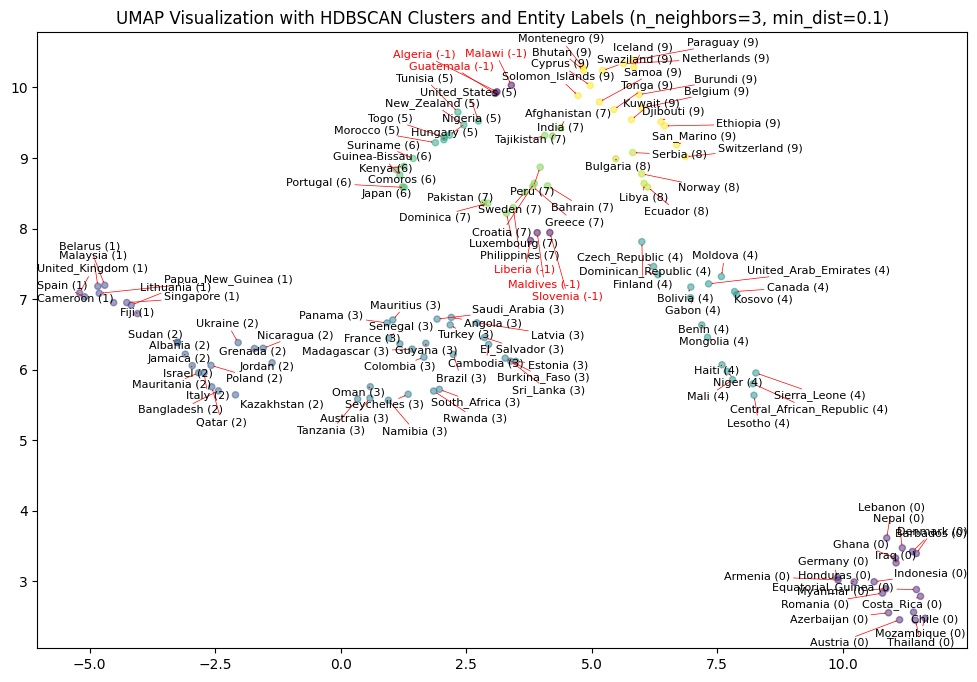

Number of Clusters: 10


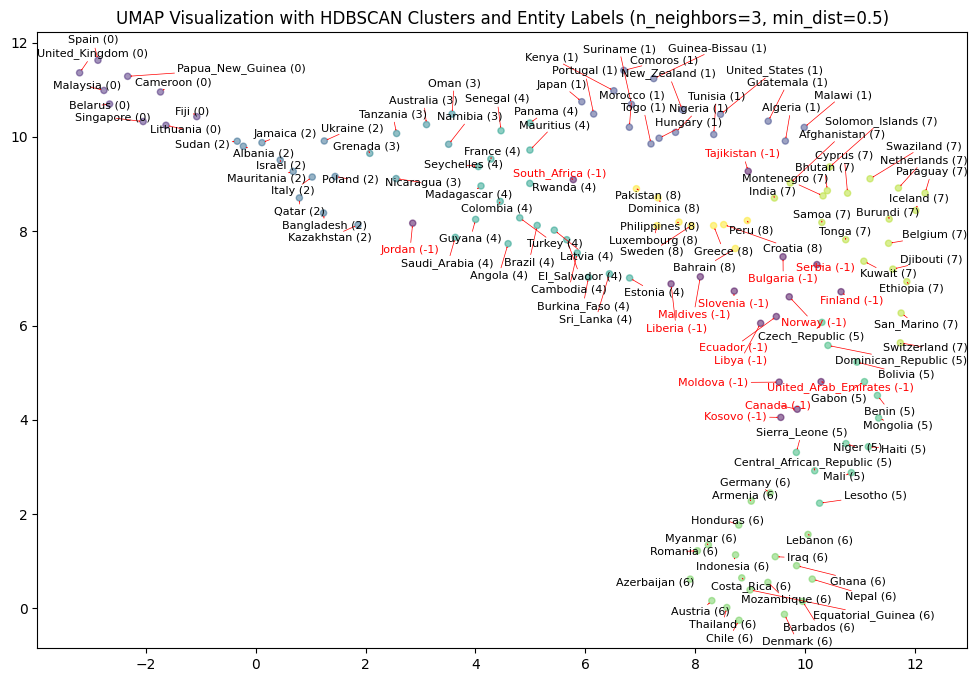

Number of Clusters: 9


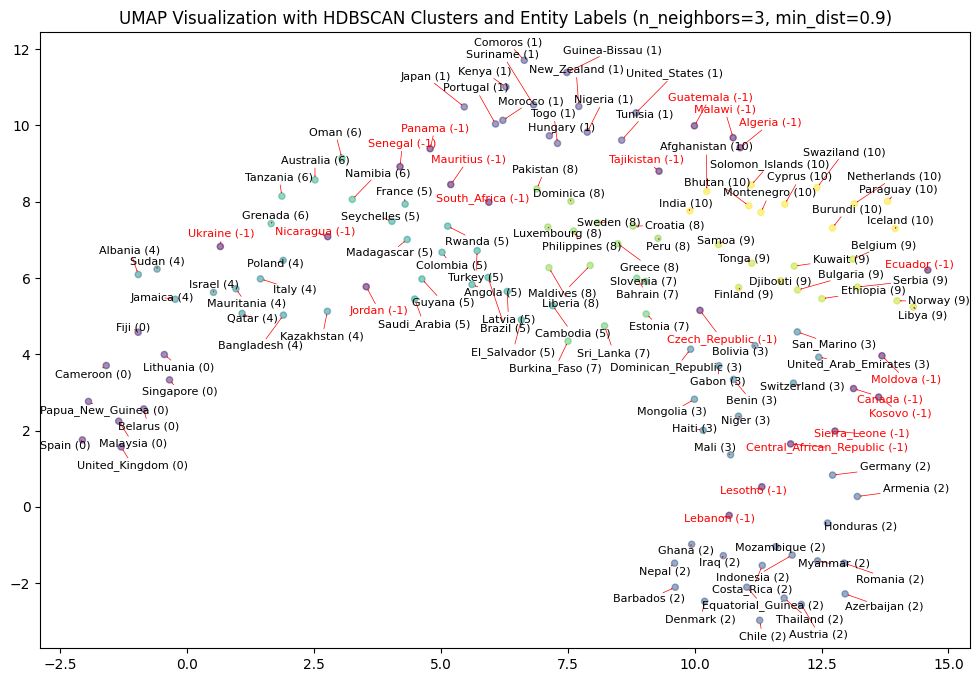

Number of Clusters: 11


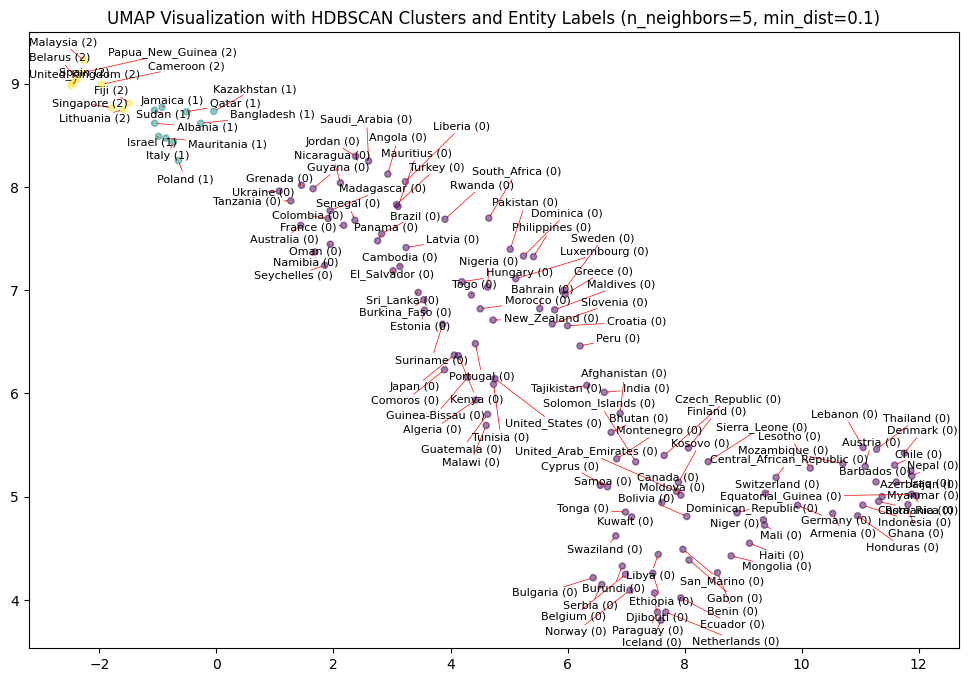

Number of Clusters: 3


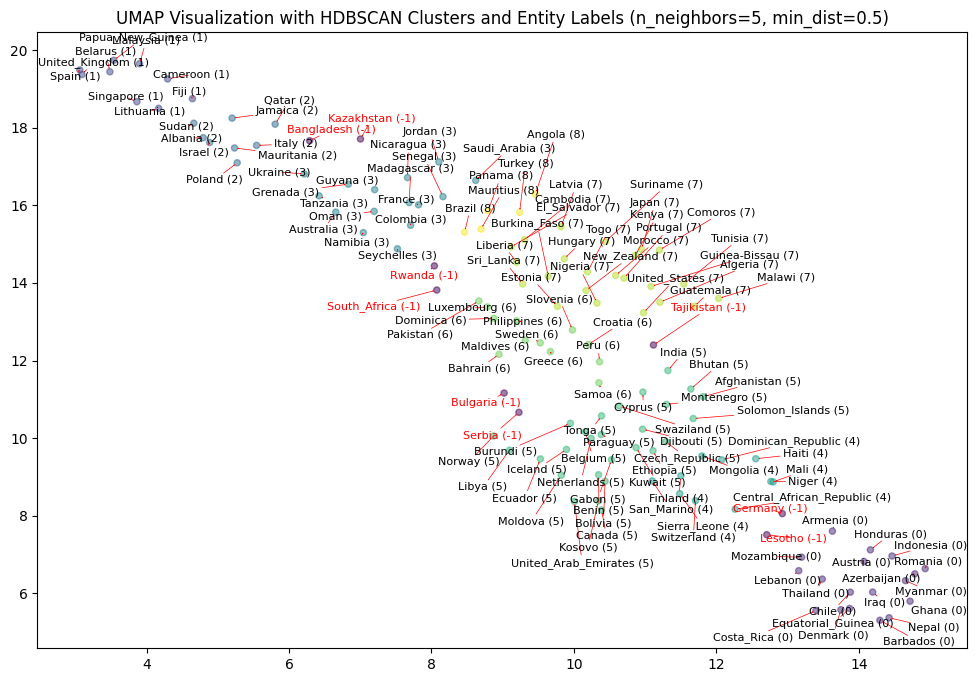

Number of Clusters: 9


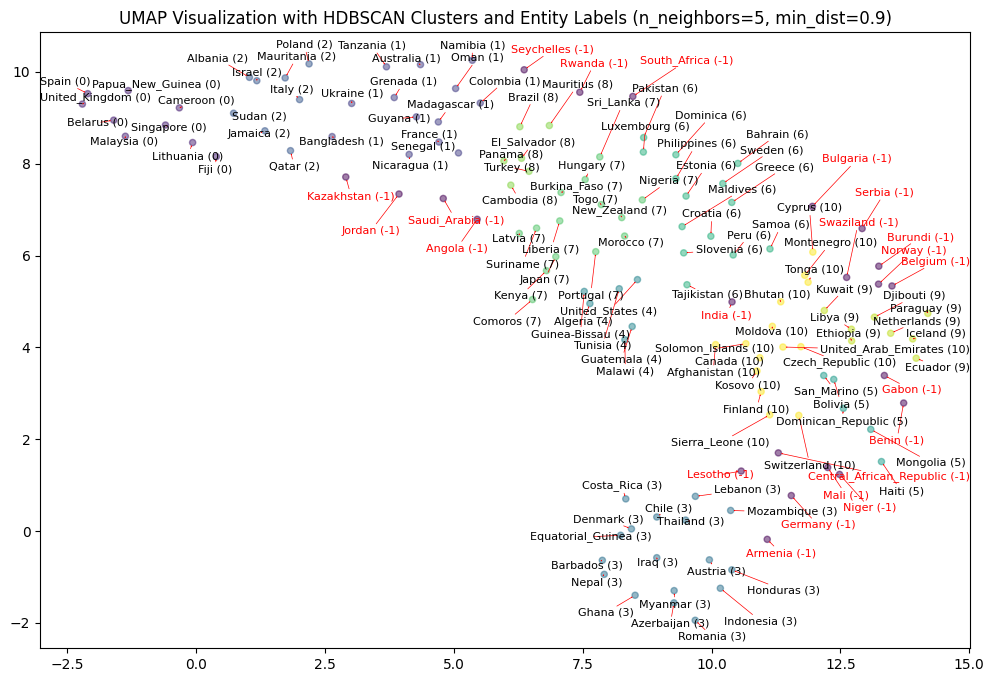

Number of Clusters: 11


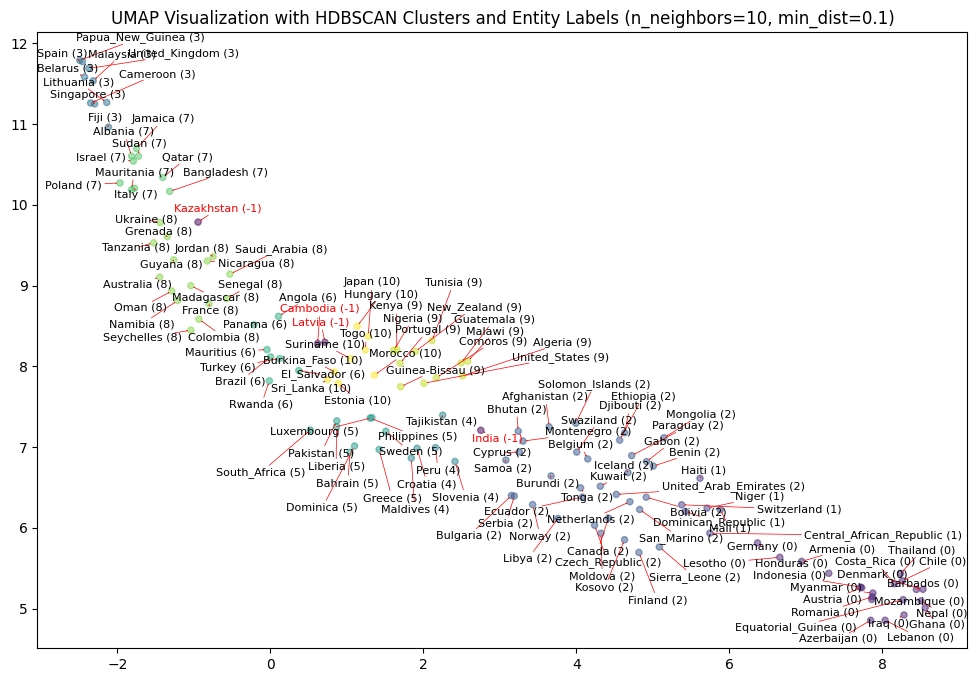

Number of Clusters: 11


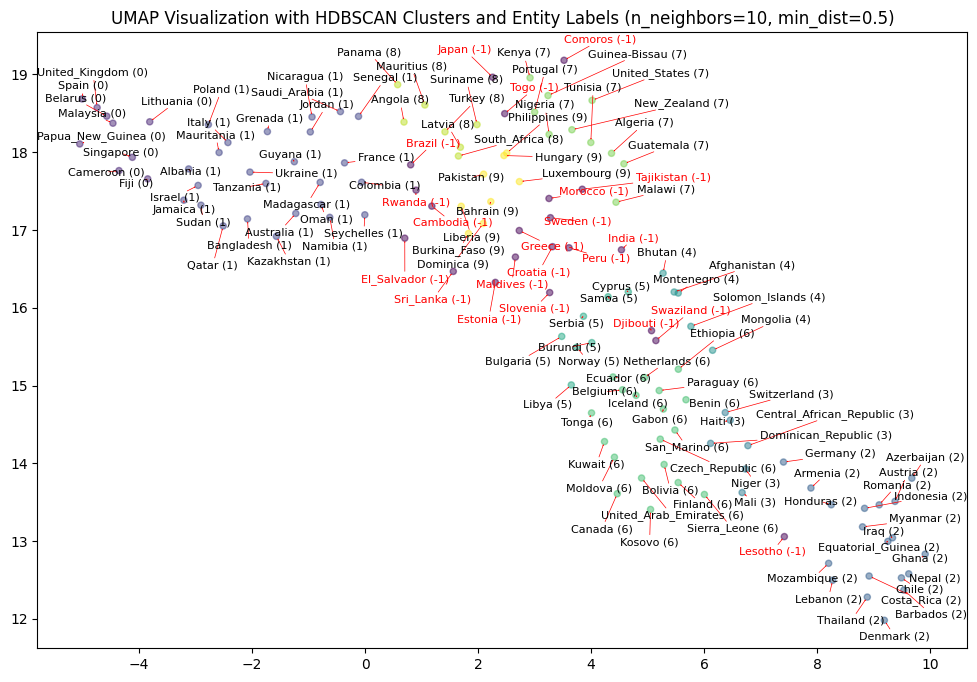

Number of Clusters: 10


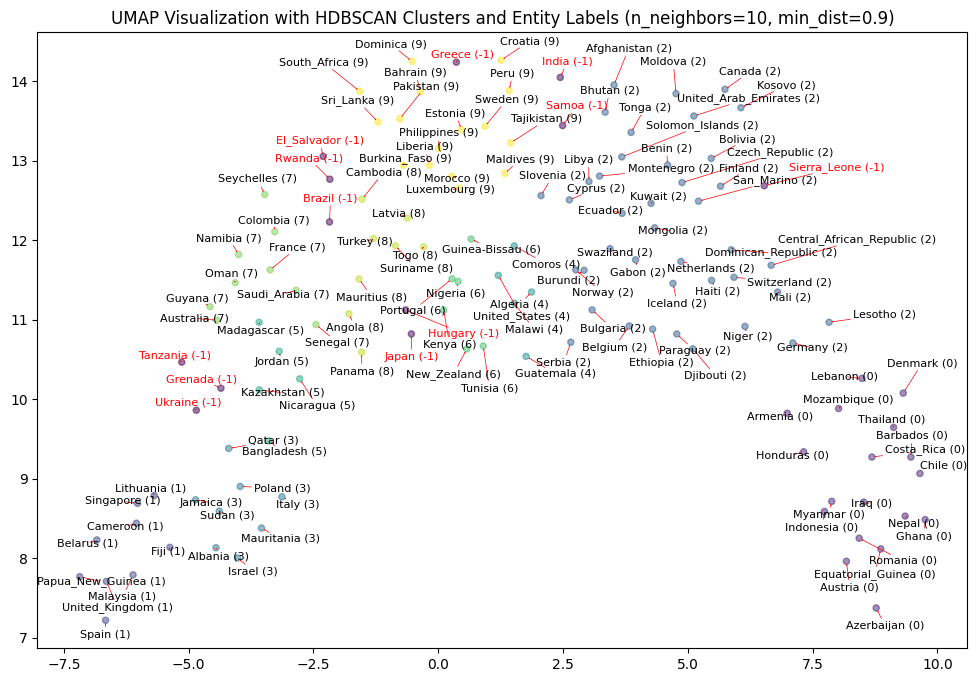

Number of Clusters: 10


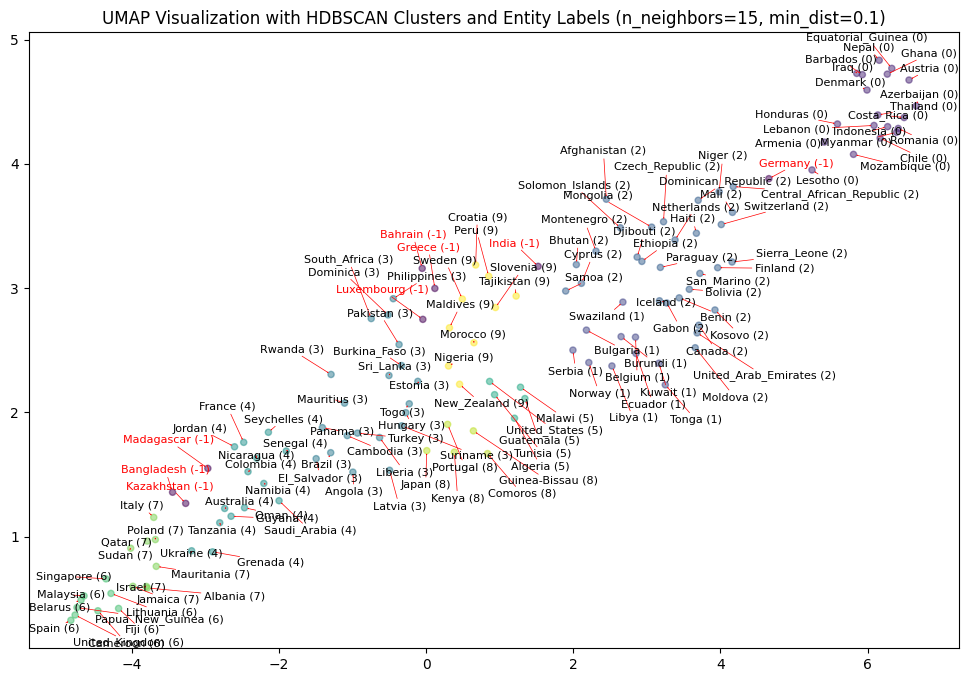

Number of Clusters: 10


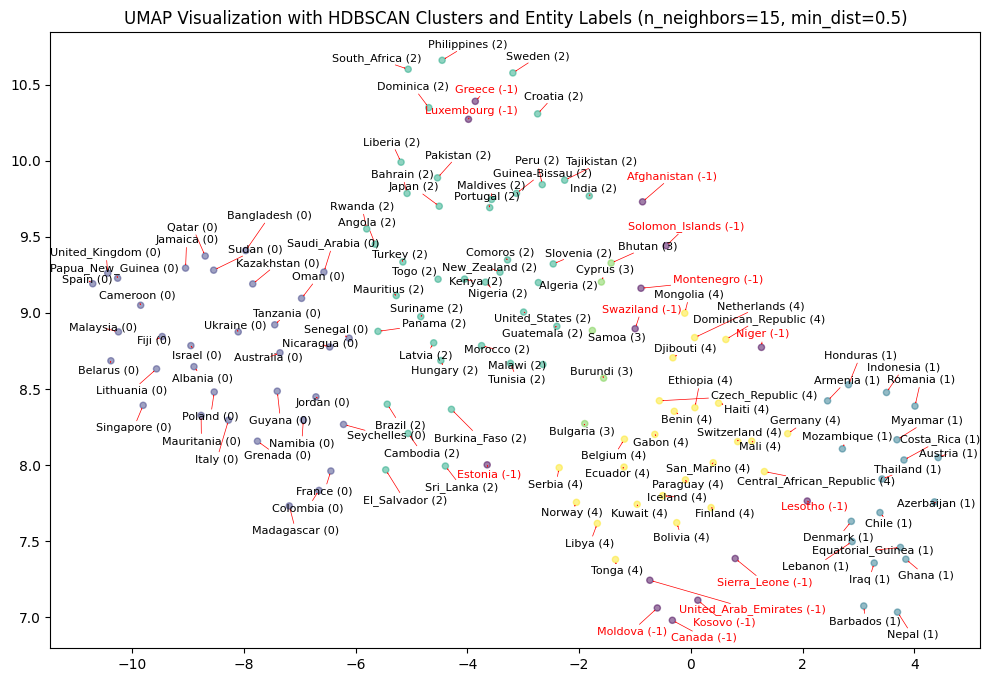

Number of Clusters: 5


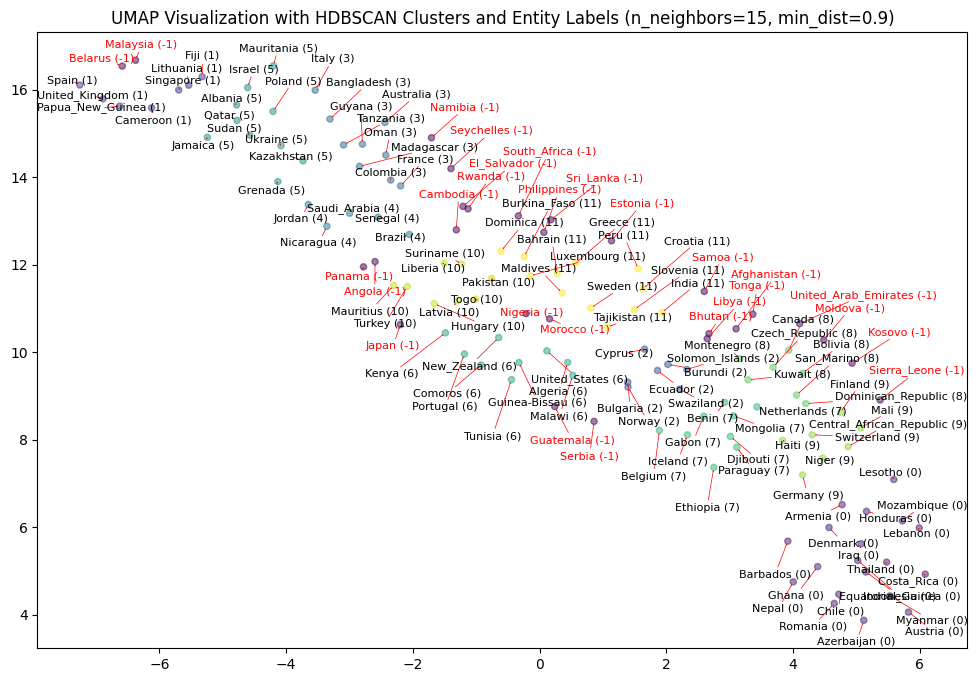

Number of Clusters: 12


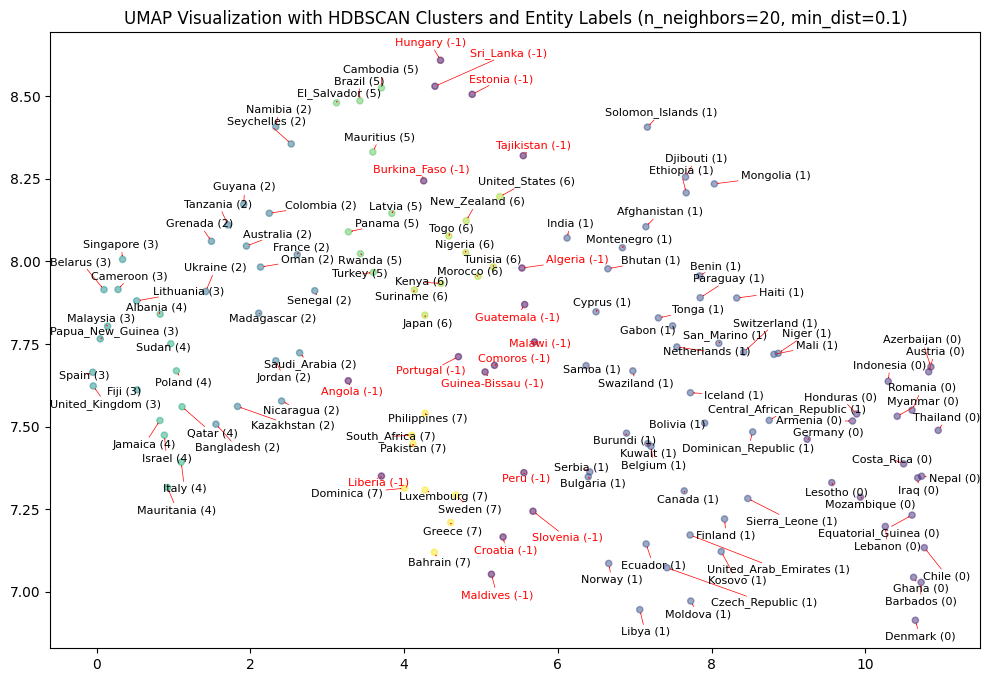

Number of Clusters: 8


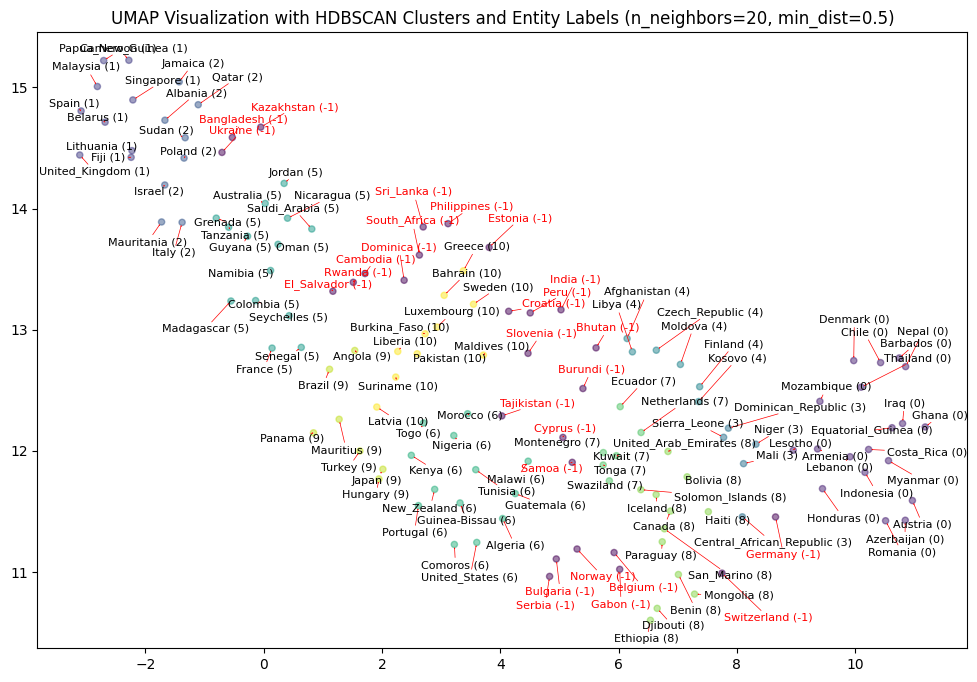

Number of Clusters: 11


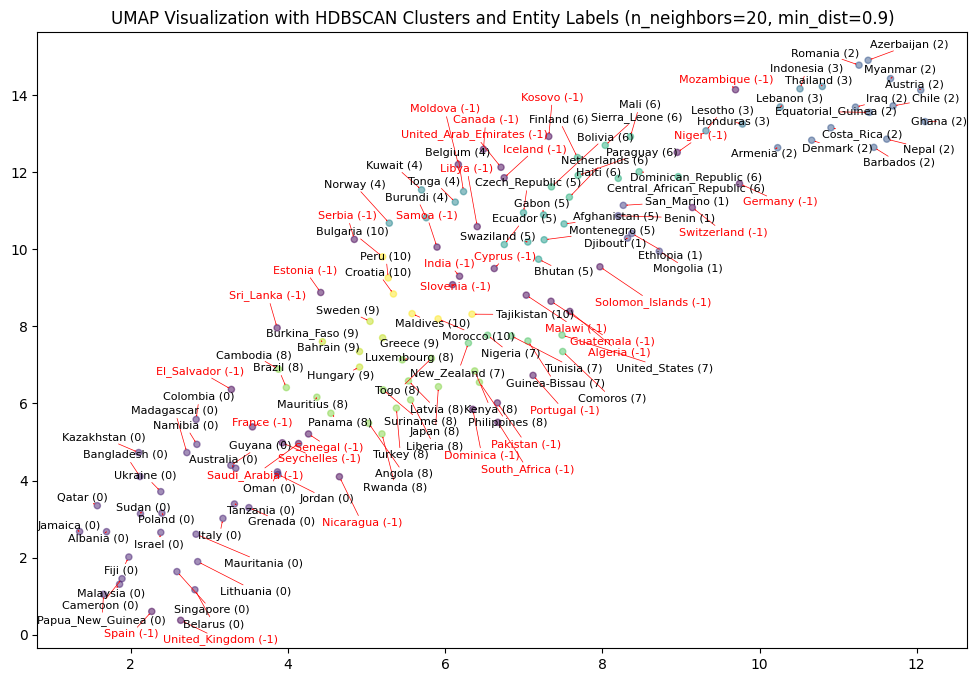

Number of Clusters: 11


In [ ]:
import umap
import matplotlib.pyplot as plt
from adjustText import adjust_text
import hdbscan

# Assuming X_umap is embeddings array
# Assuming entities are entity labels

# Values to try for n_neighbors and min_dist
n_neighbors_values = [3, 5, 10, 15, 20]
min_dist_values = [0.1, 0.5, 0.9]

# Iterate over different values of n_neighbors and min_dist
for n_neighbors in n_neighbors_values:
    for min_dist in min_dist_values:
        # Calculate UMAP embeddings
        X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42).fit_transform(embeddings)

        # Perform HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
        cluster_labels = clusterer.fit_predict(X_umap)

        # Visualize with different colors for each cluster using matplotlib
        plt.figure(figsize=(12, 8))

        # Adjust the size (s) and alpha for better visualization
        scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

        # Annotate points with entity labels and cluster labels
        texts = []
        for x, y, lab, cluster_label in zip(X_umap[:, 0], X_umap[:, 1], entities, cluster_labels):
            lab_short = lab.split('/')[-1]
            text_color = 'red' if cluster_label == -1 else 'black'
            text = plt.text(x, y, f"{lab_short} ({cluster_label})", fontsize=8, color=text_color)
            texts.append(text)

        # Adjust text labels to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), iter_lim=50)

        plt.title(f'UMAP Visualization with HDBSCAN Clusters and Entity Labels (n_neighbors={n_neighbors}, min_dist={min_dist})')
        plt.show()

        # Print the number of clusters (-1 indicates outliers)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        print(f"Number of Clusters: {num_clusters}")